<a href="https://colab.research.google.com/github/shaifali1102/Supervised-Learning/blob/main/Bagging%26RF_Practise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ensembles

- many base learners(models) are combined smartly as differently as possible
- types of ensembles:
    1. Bagging(RF)
    2. Boosting(GBDT)
    3. Stacking
    4. Cascading

## Bagging

- bagging is bootstapped aggregating
    - bootstapping: random sampling with replacement from a population of data
    - aggregating: clubbing predictions of each model to get the final outcome

## Random Forest
- a bagging ensemble technique where DTs are the base learners
- Row & Column Sampling:
    - each tree is trained on a random subset of rows and columns
    - column sampling is done without replacement
- Working:
    1. assume we have a dataset(D) with n rows(records) and d columns(features)
    2. sampling
        - row sampling = m1 data points with replacement
        - column sampling = d' columns
        - dataset = D1
    3. repeat sampling k times to get Dk
    4. train k different base learners (M1, M2, M3, ... Mk) on these datasets
    5. perform aggregation:
        - classification: majority vote
        - regression: mean/median
- Why do we need randomness
    - we use row and column sampling to ensure that each tree sees a slightly *different version* of the data creating a collection of diverse, uncorrelated trees
    - if the trees were trained on exact same data and features, they would be highly correlated and prone to *overfitting*.
    - when diversified, the *individual bias and errors* of the trees tend to cancel each other out during the aggregation step where we take the majoriy vote for classification and average for regression.
- Validating RF
    - validating each model by using the OOB points in n-m rows that were not selected in row sampling
    - OOB score is used to measure overall performance
        - we take majority vote/ mean of pred for points in OOB set from all models and compare with actual label of the datapoints
        - we do this for all points to get the OOB score
        - when our dataset is not large enough, we cannot afford to keep a subset for validation, we estimate overall model performance from individual model performances on the OOB points
- Bias-Variance Tradeoff
    - The base learners in RF are deep DTs, that can lead to low bias and high variance, hence, overfitting
    - we reduce variance by using aggregation
        - when we take average of pred values, +ve errors cancel out -ve errors.
        - thus, we are left with smaller residual errors
- Error in RF
$$
Error = Bias^2 + Variance + Irreducible~error
$$
    - Because of aggregation, variance decreases without trading off bias
    - we get low bias, low variance
    - what is irreducible error?
        - inherent noise or randomness in data that cannot be explained or reduced by the model
- Outliers in DTs/RF
    - DTs are robust to outliers
        - individual DTs split data based on feature values
        - an outlier won't drastically pull/wrap the decision boundary around it
    - RF are also robust to outliers
        - because of the ensemble aggregating
        - the effect of a few trees being influenced by an outlier is mitigated by the majority of the trees that were not significantly affected
- Training an RF Model
    - each model can be trained independently
    - therefore the training of individual models can be parallelised
    - we can use distributed computing for parallel processing
        - Distributed computing is when multiple independent computers/nodes work together as a single unified system to achieve a common goal
        -it can also be different processing cores on a single powerful machine
        - tasks are broken down and distributed among these interconnected computers as they communicate and coordinate their efforts to solve a larger problem
        - this supports parallelism and scalability
        - fault tolerance : if one machine fails, others can pick up its tasks, ensuring the system continues to operate
- Time & Space Complexity
    - time complexity = O(k * max_depth)
        - time complexity grows linearly with the number of trees and maximum depth of those trees
    - space complexity = O(no of nodes * k)
        - space complexity grows with the avg size of individual trees and total number of trees in the ensemble
- Hyperparameter tuning

    1. Grid Search
        - tries every possible combination of hyperparams
        - chooses the optimal set
        - computationally expensive and time consuming
    2. Randomised Search
        - tries random combinations of hyperparams
        - used when dealing with large hyperparams space or limited computational resources
        - search space is reduced compared to Grid Search
        - allows faster exploration
- Feature Importances
    - compute importance of a feature in each DT
    - take avg of these values
    - if the feature is not present in the DT because of column sampling, then the importance of the feature in that DT is taken as 0
    - the presence of multiple decision trees compensates for the absence of certain features in the individual trees


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Continuing with the Airtel Attrition case study

In [5]:

!gdown 1kKuLw1OePAlkBg_USs2bpPt0W3T57TLk
!gdown 1aNFX8--II7zWcxtVyAM-G-7KvNDcQUPz
!gdown 1diorT6lGMBS_gOEYv0iznsFbMi8Ga04Y
!gdown 1EuzXHX_7q7o7xAbS58ZW91pb7dF_7zTT

Downloading...
From: https://drive.google.com/uc?id=1kKuLw1OePAlkBg_USs2bpPt0W3T57TLk
To: /content/X_train.pkl
100% 491k/491k [00:00<00:00, 84.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aNFX8--II7zWcxtVyAM-G-7KvNDcQUPz
To: /content/y_train.pkl
100% 15.4k/15.4k [00:00<00:00, 35.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1diorT6lGMBS_gOEYv0iznsFbMi8Ga04Y
To: /content/X_test.pkl
100% 102k/102k [00:00<00:00, 66.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EuzXHX_7q7o7xAbS58ZW91pb7dF_7zTT
To: /content/y_test.pkl
100% 9.46k/9.46k [00:00<00:00, 22.3MB/s]


In [8]:
import pickle

with open('X_train.pkl','rb') as handle:
  X_train = pickle.load(handle)

with open('X_test.pkl','rb') as handle:
  X_test = pickle.load(handle)

with open('y_train.pkl','rb') as handle:
  y_train = pickle.load(handle)

with open('y_test.pkl','rb') as handle:
  y_test = pickle.load(handle)

DT train score was 0.8322510822510822 and test score was 0.779891304347826 for most optimal max_depth = 4

## Random Forest Implementation

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, max_depth=4, n_estimators=100)

In [12]:
from sklearn.model_selection import KFold, cross_validate

kf = KFold(n_splits=10)

c_score = cross_validate(rf, X_train, y_train, cv=kf, scoring='accuracy',return_train_score=True)

print(f'Train score: Mean: {c_score["train_score"].mean()*100} Validate score: Mean: {c_score["test_score"].mean()*100}')
print(f'Train score: Std: {c_score["train_score"].std()*100} Validate score: Std: {c_score["test_score"].std()*100}')

Train score: Mean: 88.67246403626439 Validate score: Mean: 83.61104582843714
Train score: Std: 0.5062272245590862 Validate score: Std: 4.719666144470417


the test accuracy has increased from 78% to 83%


## Hyperparameter tuning

In [13]:
# parameters

params = {
    'n_estimators': [100,200,300,400],
    'max_depth': [3,4,5,6,10],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True,False],
    'max_features': [8,9,10]
}

In [14]:
# Grid Search

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=params,
                    scoring='accuracy',
                    cv=3,
                    n_jobs=-1 #use all processors
                    )

In [15]:
grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best params:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'n_estimators': 300}
Best score:  0.9128787878787877


Test accuracy has increased to

In [18]:
# Randomized Search

from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                            param_distributions=params,
                            scoring='accuracy',
                            cv=3,
                            n_iter=15,
                            n_jobs=-1
                            )

In [19]:
random.fit(X_train, y_train)

print("best params: ", random.best_params_)
print("best score: ", random.best_score_)

best params:  {'n_estimators': 200, 'max_features': 10, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
best score:  0.9096320346320347


Grid Search gives most optimal solution but Randomized Search is much faster than Grid search

Applying the best params

In [21]:
rf2 = RandomForestClassifier(random_state=42, bootstrap=True, criterion='gini', max_depth=10, max_features=8,n_estimators=300)

kfold = KFold(n_splits=10)

c_score = cross_validate(rf2, X_train, y_train, cv=kf, scoring='accuracy', return_train_score=True)

print(f'Train score: Mean: {c_score["train_score"].mean()*100} Validate score: Mean: {c_score["test_score"].mean()*100}')
print(f'Train score: Std: {c_score["train_score"].std()*100} Validate score: Std: {c_score["test_score"].std()*100}')

Train score: Mean: 99.92784847819047 Validate score: Mean: 92.26792009400707
Train score: Std: 0.03608178658543543 Validate score: Std: 5.068680373057548


We were able to get a validation score of 92%!

Calculating Feature Importances

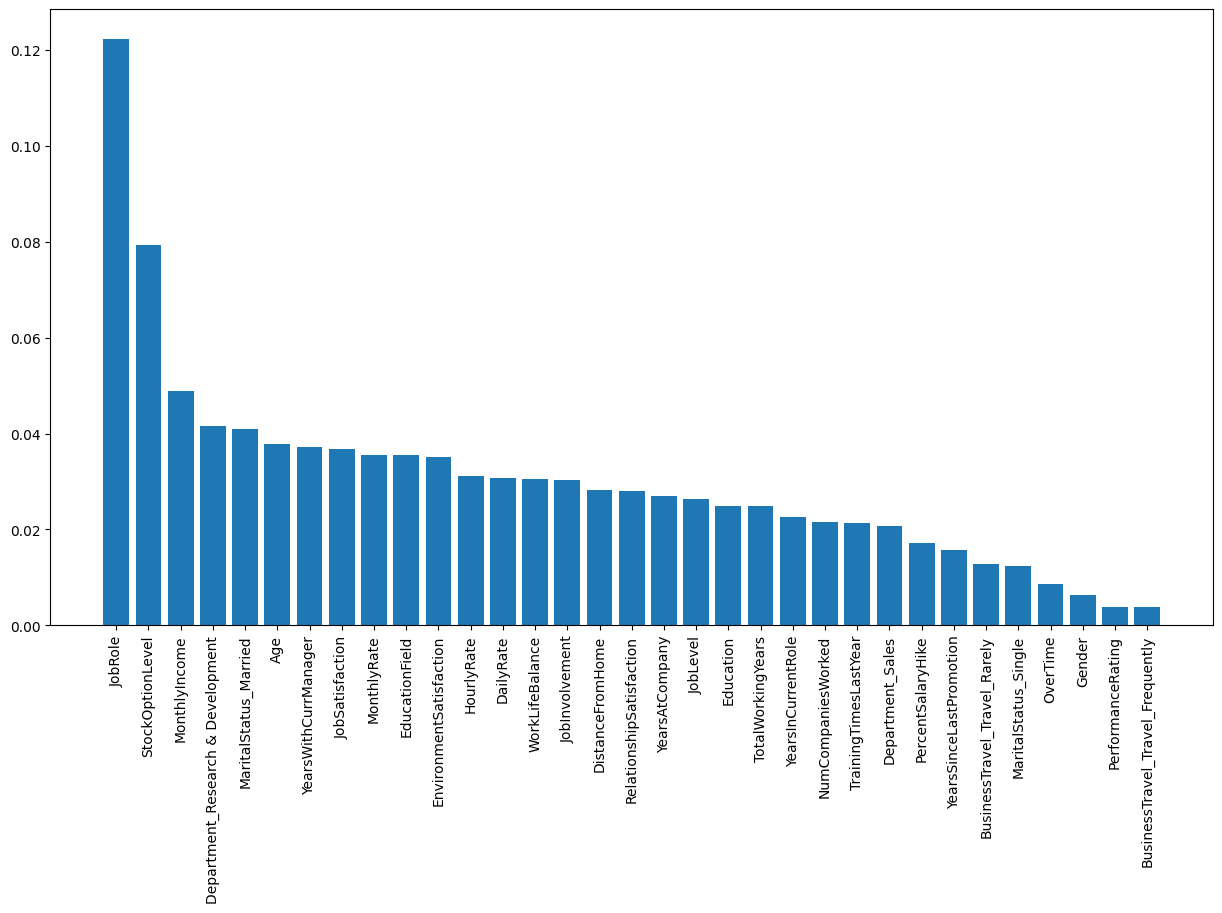

In [27]:
rf2.fit(X_train, y_train)

imp = rf2.feature_importances_

indices = np.argsort(imp)[::-1] # sort in desc order
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(15,8))
plt.bar(range(X_train.shape[1]), imp[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

JobRole is the most important feature followed by StockOptionalLevel and MonthlyIncome